# Attempt to convert code to jax

In [12]:
# Importing required packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import jax.numpy as jnp
from jax import grad, jit, vmap
import iminuit 
import math
import jax

In [2]:
# Importing data on Antikythera Mechanism (AM) as data_AM
data_AM = pd.read_csv("data/1-Fragment_C_Hole_Measurements.csv")

# Printing data
data_AM  

,Section ID,Hole,Inter-hole Distance,Mean(X),Mean(Y)
0,0,1,NaN,15.59931,92.59653
1,1,2,NaN,16.44167,91.50069
2,1,3,1.440694,17.30764,90.34931
3,1,4,1.456973,18.15278,89.16250
4,1,5,1.299821,18.96528,88.14792
...,...,...,...,...,...
76,7,77,1.259985,108.69444,63.42778
77,7,78,1.430105,110.05486,63.86875
78,7,79,1.179606,111.14583,64.31736
79,7,80,1.428043,112.48021,64.82604


In [3]:
sub_data = data_AM[~data_AM['Section ID'].isin([0,4])] # removing sections 0 and 4
sub_data.shape # Quick check

(79, 5)

In [20]:
sub_data

,Section ID,Hole,Inter-hole Distance,Mean(X),Mean(Y)
1,1,2,NaN,16.44167,91.50069
2,1,3,1.440694,17.30764,90.34931
3,1,4,1.456973,18.15278,89.16250
4,1,5,1.299821,18.96528,88.14792
5,1,6,1.372859,19.81389,87.06875
...,...,...,...,...,...
76,7,77,1.259985,108.69444,63.42778
77,7,78,1.430105,110.05486,63.86875
78,7,79,1.179606,111.14583,64.31736
79,7,80,1.428043,112.48021,64.82604


In [21]:
# Converting Section ID into array format using .to_numpy()
sec_id_sub = sub_data['Section ID'].to_numpy()
print('Section ID before adaptation to new format:')
print(sec_id_sub)

print('')

'''  
For our likelihood models we have labeled sections from 0 to 5, but the observed data is 
registered with section id from 1 to 7, exluding sections 0 and 4. 

The objective is to relabel the Section ID from 0 to 5, by subtracting 1 when elements in Section ID
are less than 4, and subtract 2 otherwise.

'''

sec_mod = jnp.array([x-1 if x < 4 else x - 2 for x in sec_id_sub]) 
print('Section ID adapted to new format:')
print(sec_mod)

Section ID before adaptation to new format:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 5 5 6 6 7
 7 7 7 7 7]

Section ID adapted to new format:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 4 4 5
 5 5 5 5 5]


In [36]:
hole_d, x_d, y_d = jnp.array(sub_data['Hole'].to_numpy()), jnp.array(sub_data['Mean(X)'].to_numpy()), jnp.array(sub_data['Mean(Y)'].to_numpy())

Original code

In [ ]:
def rad_tang_model(sections_ids, hole_ids, x_obs = None, y_obs = None):

    # Defining our uniform priors
    N = numpyro.sample('N', numpyro.distributions.Uniform(340,370)) 
    r = numpyro.sample('r', numpyro.distributions.Uniform(74, 80))
    
    # Errors 
    sigma_t = numpyro.sample('sigma_t', numpyro.distributions.LogUniform(0.01,0.5))
    sigma_r = numpyro.sample('sigma_r', numpyro.distributions.LogUniform(0.01,0.5))

    n_parameters = len(np.unique(sections_ids))

    with numpyro.plate('transform', n_parameters):
        x_centre = numpyro.sample('x_centre', numpyro.distributions.Uniform(76,86))
        y_centre = numpyro.sample('y_centre', numpyro.distributions.Uniform(130,140))
        alpha_pred = numpyro.sample('alpha_pred', numpyro.distributions.Uniform(-3, -2))

    # Defining model
    phase = 2*jnp.pi*(hole_ids - 1)/N  + alpha_pred[sections_ids]

    x_pred = r*jnp.cos(phase) + x_centre[sections_ids]
    y_pred = r*jnp.sin(phase) + y_centre[sections_ids]

    # Defining covariance matrix (Cartesian)
    Sigma = jnp.array(
        [jnp.array([[jnp.cos(phi), jnp.sin(phi)],[jnp.sin(phi), -jnp.cos(phi)]]).T @ jnp.array([[sigma_r**2, 0],[0, sigma_t**2]]) @ jnp.array([[jnp.cos(phi), jnp.sin(phi)],[jnp.sin(phi), -jnp.cos(phi)]]) for phi in phase]
    )

    with numpyro.plate('data', len(hole_ids)):
        numpyro.sample('obs', numpyro.distributions.MultivariateNormal(loc=jnp.vstack((x_pred, y_pred)).T, covariance_matrix=Sigma), obs = jnp.vstack((x_obs, y_obs)).T)


    

### HMC



In [9]:
from numpyro.infer import NUTS, MCMC

Radial-tangential Model

In [57]:
nuts_kernel = NUTS(rad_tang_model)

mcmc_rt = MCMC(nuts_kernel, num_samples=10000, num_warmup=1000)
rng_key = jax.random.key(0)
mcmc_rt.run(rng_key, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_rt = mcmc_rt.get_samples()

sample: 100%|██████████| 11000/11000 [11:38<00:00, 15.75it/s, 1023 steps of size 8.75e-03. acc. prob=0.95]


In [59]:
mcmc_rt.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            N    355.29      1.41    355.30    353.03    357.65   1776.64      1.00
alpha_pred[0]     -2.54      0.00     -2.54     -2.55     -2.54   2674.42      1.00
alpha_pred[1]     -2.54      0.00     -2.54     -2.55     -2.54   3788.59      1.00
alpha_pred[2]     -2.54      0.00     -2.54     -2.55     -2.53   1805.27      1.00
alpha_pred[3]     -2.56      0.02     -2.56     -2.59     -2.53   4759.64      1.00
alpha_pred[4]     -2.55      0.03     -2.55     -2.60     -2.51   4766.33      1.00
alpha_pred[5]     -2.58      0.01     -2.58     -2.59     -2.57   2862.68      1.00
            r     77.34      0.28     77.35     76.90     77.83   1716.81      1.00
      sigma_r      0.03      0.00      0.03      0.02      0.03   8015.67      1.00
      sigma_t      0.13      0.01      0.13      0.11      0.15   9387.15      1.00
  x_centre[0]     79.69      0.20     79.70     79.38     80.05   1814.61  

Collecting predicted information for plotting

In [60]:
N_rt_pred = jnp.mean(posterior_samples_rt['N'])
R_rt_pred = jnp.mean(posterior_samples_rt['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_rt = jnp.mean(posterior_samples_rt["alpha_pred"], axis=0)
xcents_opt_rt = jnp.mean(posterior_samples_rt["x_centre"], axis=0)
ycents_opt_rt = jnp.mean(posterior_samples_rt["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_rt = jnp.array([phases_opt_rt, xcents_opt_rt, ycents_opt_rt])

Isotropic model

In [54]:
def isotropic_model(sections_ids, hole_ids, x_obs = None, y_obs = None):

    # Defining our uniform priors
    N = numpyro.sample('N', numpyro.distributions.Uniform(340,370)) 
    r = numpyro.sample('r', numpyro.distributions.Uniform(74, 80))
    
    # Errors 
    sigma = numpyro.sample('sigma', numpyro.distributions.LogUniform(0.01, 1))

    n_parameters = len(np.unique(sections_ids))

    with numpyro.plate('transform', n_parameters):
        x_centre = numpyro.sample('x_centre', numpyro.distributions.Uniform(76,86))
        y_centre = numpyro.sample('y_centre', numpyro.distributions.Uniform(130,140))
        alpha_pred = numpyro.sample('alpha_pred', numpyro.distributions.Uniform(-3, -2))

    # Defining model
    phase = 2*jnp.pi*(hole_ids - 1)/N  + alpha_pred[sections_ids]

    x_pred = r*jnp.cos(phase) + x_centre[sections_ids]
    y_pred = r*jnp.sin(phase) + y_centre[sections_ids]

    # Defining covariance matrix (Cartesian)
    Sigma = jnp.array([jnp.array([[sigma**2, 0],[0, sigma**2]]) for _ in phase])

    with numpyro.plate('data', len(hole_ids)):
        numpyro.sample('obs', numpyro.distributions.MultivariateNormal(loc=jnp.vstack((x_pred, y_pred)).T, covariance_matrix=Sigma), obs = jnp.vstack((x_obs, y_obs)).T)

In [58]:
nuts_kernel = NUTS(isotropic_model)

mcmc_iso = MCMC(nuts_kernel, num_samples=10000, num_warmup=1000)
rng_key_iso = jax.random.key(0)
mcmc_iso.run(rng_key_iso, sec_mod, hole_d, x_obs = x_d, y_obs = y_d)

posterior_samples_iso = mcmc_iso.get_samples()

sample: 100%|██████████| 11000/11000 [03:54<00:00, 46.92it/s, 511 steps of size 9.25e-03. acc. prob=0.88] 


In [61]:
mcmc_iso.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
            N    355.60      4.30    355.64    348.56    362.66   1632.51      1.00
alpha_pred[0]     -2.54      0.00     -2.54     -2.55     -2.54   2534.39      1.00
alpha_pred[1]     -2.54      0.01     -2.54     -2.56     -2.52   3651.13      1.00
alpha_pred[2]     -2.54      0.01     -2.54     -2.56     -2.52   1672.33      1.00
alpha_pred[3]     -2.56      0.04     -2.56     -2.61     -2.49   4263.12      1.00
alpha_pred[4]     -2.55      0.04     -2.55     -2.61     -2.48   3730.15      1.00
alpha_pred[5]     -2.58      0.02     -2.58     -2.62     -2.54   2466.88      1.00
            r     77.42      0.93     77.43     75.86     78.91   1629.20      1.00
        sigma      0.09      0.01      0.09      0.09      0.10   8310.14      1.00
  x_centre[0]     79.74      0.66     79.73     78.69     80.86   1717.53      1.00
  x_centre[1]     79.95      0.74     79.94     78.80     81.19   3277.33  

Collecting predicted information for plotting

In [62]:
N_is_pred = jnp.mean(posterior_samples_iso['N'])
R_is_pred = jnp.mean(posterior_samples_iso['r'])

num_sections = 6  # Assuming 6 sections

phases_opt_iso = jnp.mean(posterior_samples_iso["alpha_pred"], axis=0)
xcents_opt_iso = jnp.mean(posterior_samples_iso["x_centre"], axis=0)
ycents_opt_iso = jnp.mean(posterior_samples_iso["y_centre"], axis=0)

# Store all extracted parameters in a structured array
optimised_params_iso = jnp.array([phases_opt_iso, xcents_opt_iso, ycents_opt_iso])

In [ ]:
def hole_prediction(N, R, optim_parm):

    '''  
    Function to compute prediction of hole location on the xy-plane.

    Parameters:
    
    N : Int
        Number of predicted holes
    
    R : Int
        Predicted radius of the original circle

    optim_parm : 
        Predicted parameters (x_0j, y_0j, alpha_j)

    Returns:
        np.array([x_pred, y_pred]), array of predicted x and y values.

    '''

    x_pred = [] # x_ij
    y_pred = [] # y_ij
    
    # 79 measured holes
    for i in range(0, 79):

        phi_val = 2*jnp.pi*(i)/N + optim_parm[0][sec_mod[i]] # Computing phi_ij values

        x_val = R*jnp.cos(phi_val) + optim_parm[1][sec_mod[i]] # Computing x_ij values
        y_val = R*jnp.sin(phi_val) + optim_parm[2][sec_mod[i]] # Computing x_ij values

        x_pred.append(x_val)
        y_pred.append(y_val)
    
    return jnp.array([x_pred, y_pred])

<b>Computing the predicted hole location for each model</b>

In [64]:
# Computing hole predicted location using predicted parameters from Iminuit for:

# Radial-Tangential Model:
predicted_hole_loc_rt = hole_prediction(N_rt_pred, R_rt_pred, optimised_params_rt)

# Isotropic Model:
predicted_hole_loc_is = hole_prediction(N_is_pred, R_is_pred, optimised_params_iso)

In [65]:
# Constructiong Data Frame for:

# Radial-Tangential Model

d_rt = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_rt[0],
    'Mean(Y)' : predicted_hole_loc_rt[1]
}

pred_data_rt_HMC = pd.DataFrame(d_rt)

# Checking result
pred_data_rt_HMC

,Section ID,Hole,Mean(X),Mean(Y)
0,1,2,15.785290,92.473389
1,1,3,16.565670,91.350021
2,1,4,17.365780,90.240646
3,1,5,18.185390,89.145584
4,1,6,19.024231,88.065201
...,...,...,...,...
74,7,77,106.071640,62.535492
75,7,78,107.374748,62.951195
76,7,79,108.670319,63.389877
77,7,80,109.957901,63.851395


In [66]:
# Radial-Tangential Model

d_is = {

    'Section ID' : sub_data['Section ID'].to_numpy(),
    'Hole' : sub_data['Hole'].to_numpy(),
    'Mean(X)' : predicted_hole_loc_is[0],
    'Mean(Y)' : predicted_hole_loc_is[1]
}

pred_data_is_HMC = pd.DataFrame(d_is)

# Checking result
pred_data_is_HMC

,Section ID,Hole,Mean(X),Mean(Y)
0,1,2,15.787384,92.481262
1,1,3,16.568371,91.358231
2,1,4,17.369080,90.249176
3,1,5,18.189274,89.154419
4,1,6,19.028667,88.074333
...,...,...,...,...
74,7,77,106.063805,62.519173
75,7,78,107.366943,62.935120
76,7,79,108.662529,63.374023
77,7,80,109.950150,63.835747


Plotting Radial-Tangential Model vs Observed Data (HMC)

/tmp/ipykernel_1025/1616940545.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))


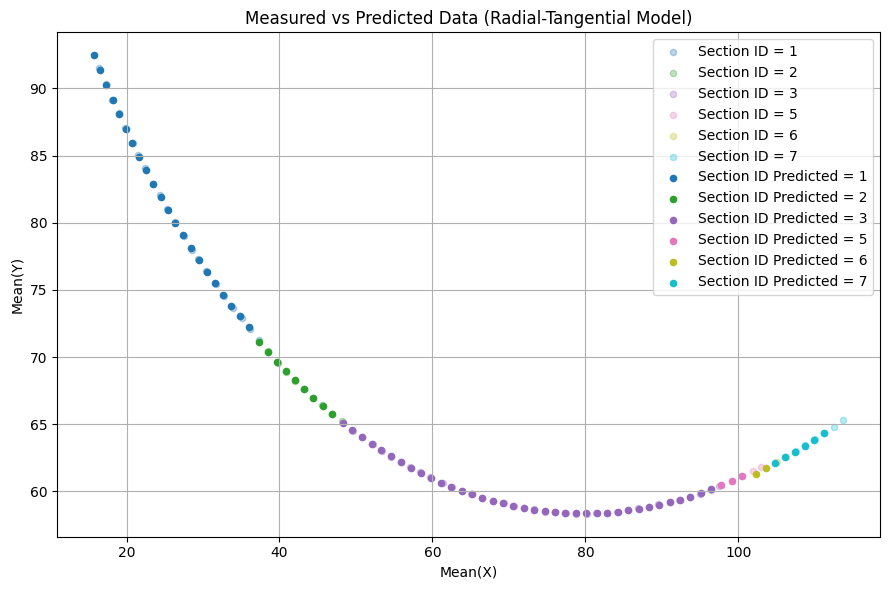

In [67]:
# Define colors using a colormap
colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))

# Plot
plt.figure(figsize=(9, 6))

# Loop through each section and plot automatically
# Selecting different region based on Section ID
for i, (section, data) in enumerate(sub_data.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, alpha = 0.3, color=colors(i), label=f"Section ID = {section}")

for i, (section, data) in enumerate(pred_data_rt_HMC.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID Predicted = {section}")

# Add labels and title
plt.xlabel('Mean(X)')
plt.ylabel('Mean(Y)')
plt.title('Measured vs Predicted Data (Radial-Tangential Model)')

# Invert y-axis for better visualization (resemble ring shape)
#plt.gca().invert_yaxis()

# Add legend, adjust layout and grid
plt.legend()
plt.tight_layout()
plt.grid()

# Show plot
plt.show()

Plotting Isotropic Model vs Observed Data (HMC)

/tmp/ipykernel_1025/2540341742.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))


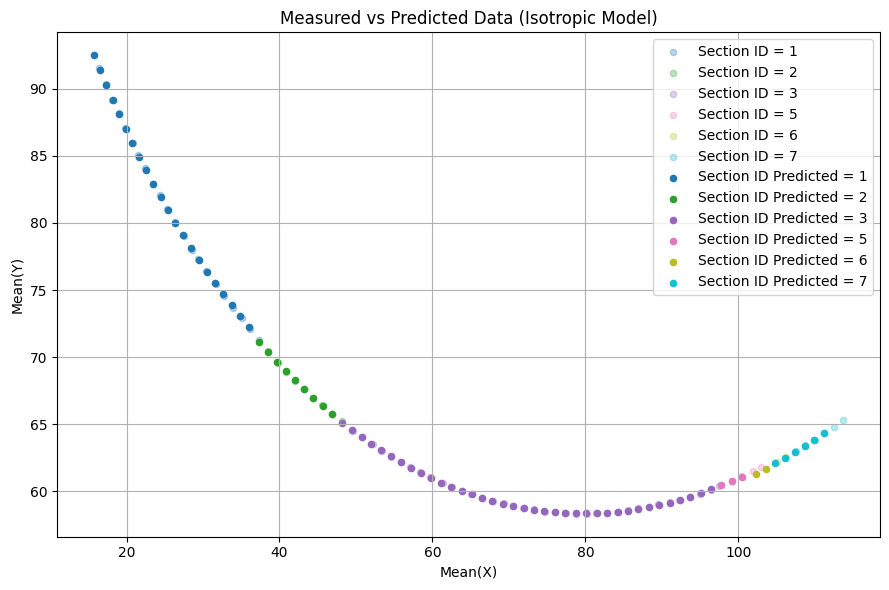

In [68]:
# Define colors using a colormap
colors = plt.cm.get_cmap("tab10", len(sub_data["Section ID"].unique()))

# Plot
plt.figure(figsize=(9, 6))

# Loop through each section and plot automatically
# Selecting different region based on Section ID
for i, (section, data) in enumerate(sub_data.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, alpha = 0.3, color=colors(i), label=f"Section ID = {section}")

for i, (section, data) in enumerate(pred_data_is_HMC.groupby("Section ID")):
    plt.scatter(data["Mean(X)"], data["Mean(Y)"], s=20, color=colors(i), label=f"Section ID Predicted = {section}")

# Add labels and title
plt.xlabel('Mean(X)')
plt.ylabel('Mean(Y)')
plt.title('Measured vs Predicted Data (Isotropic Model)')

# Invert y-axis for better visualization (resemble ring shape)
#plt.gca().invert_yaxis()

# Add legend, adjust layout and grid
plt.legend()
plt.tight_layout()
plt.grid()

# Show plot
plt.show()